# Running SIPSim pipeline to simulate priming_exp gradient dataset

* Basing simulation params off of priming_exp dataset
  * Basing starting community diversity on mean percent abundances in all fraction samples for the gradient
  * Other parameters are 'default'

# Setting variables

In [7]:
workDir = '/home/nick/notebook/SIPSim/dev/priming_exp/validation_sample/X12C.700.45_fracRichness/'
genomeDir = '/home/nick/notebook/SIPSim/dev/priming_exp/genomes/'
allAmpFrags = '/home/nick/notebook/SIPSim/dev/bac_genome1210/validation/ampFrags.pkl'
otuTableFile = '/var/seq_data/priming_exp/data/otu_table.txt'
metaDataFile = '/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt'
primerFile = '/home/nick/notebook/SIPSim/dev/515F-806R.fna'

cdhit_dir = '/home/nick/notebook/SIPSim/dev/priming_exp/CD-HIT/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'
figureDir = '/home/nick/notebook/SIPSim/figures/'

# simulation params
comm_richness =  6901
seq_per_fraction = ['lognormal', 10.096, 1.116]

# for making genome_map file for genome fragment simulation
taxonMapFile = os.path.join(cdhit_dir, 'target_taxa.txt')
genomeFilterFile = os.path.join(cdhit_dir, 'genomeFile_seqID_filt.txt')
abundFile = os.path.join('/home/nick/notebook/SIPSim/dev/priming_exp/exp_info', 'X12C.700.45_frac_OTU.txt')

# misc
nprocs = 20

# Init

In [8]:
import glob
import cPickle as pickle
import copy
from IPython.display import Image

In [9]:
%load_ext rpy2.ipython

In [10]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: grid

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [11]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)

# Creating a community file from the fraction relative abundances

In [6]:
%%R -i abundFile
# reading priming experiment OTU table
tbl.abund = read.delim(abundFile, sep='\t')
tbl.abund %>% head

      OTUId mean_perc_abund median_perc_abund max_perc_abund      sample
1     OTU.1     2.191008528       2.109151822    3.455925277 X12C.700.45
2    OTU.10     0.044722200       0.035513830    0.125434932 X12C.700.45
3   OTU.100     0.234795756       0.201043020    0.469029886 X12C.700.45
4  OTU.1000     0.003686293       0.002395669    0.014643969 X12C.700.45
5 OTU.10000     0.002177551       0.002282115    0.002335085 X12C.700.45
6  OTU.1001     0.023347018       0.021015762    0.057093919 X12C.700.45


In [7]:
%%R
tbl.comm = tbl.abund %>%
    rename('taxon_name' = OTUId,
           'rel_abund_perc' = mean_perc_abund) %>%
    select(taxon_name, rel_abund_perc) %>%
    mutate(library = '1',
           rank = row_number(-rel_abund_perc)) %>%
    arrange(rank)
    
tbl.comm %>% head

  taxon_name rel_abund_perc library rank
1      OTU.1      2.1910085       1    1
2      OTU.3      1.3806520       1    2
3      OTU.8      1.3443226       1    3
4      OTU.2      1.2433854       1    4
5     OTU.13      0.9717986       1    5
6     OTU.22      0.9351165       1    6


In [8]:
%%R
# rescaling rel_abund_perc so sum(rel_abund_perc) = 100
tbl.comm = tbl.comm %>%
    group_by(library) %>%
    mutate(total = sum(rel_abund_perc)) %>% 
    ungroup() %>%
    mutate(rel_abund_perc = rel_abund_perc * 100 / total) %>%
    select(library, taxon_name, rel_abund_perc, rank)
    
tbl.comm %>% head

Source: local data frame [6 x 4]

  library taxon_name rel_abund_perc rank
1       1      OTU.1      1.8857213    1
2       1      OTU.3      1.1882769    2
3       1      OTU.8      1.1570095    3
4       1      OTU.2      1.0701365    4
5       1     OTU.13      0.8363917    5
6       1     OTU.22      0.8048207    6


In [9]:
%%R -i comm_richness
# number of OTUs
n.OTUs = tbl.comm$taxon_name %>% unique %>% length
cat('Number of OTUs:', n.OTUs, '\n')

# assertion
cat('Community richness = number of OTUs?  ', comm_richness == n.OTUs, '\n')

Number of OTUs: 6901 
Community richness = number of OTUs?   TRUE 


In [10]:
%%R -i workDir

commFile = paste(c(workDir, 'comm.txt'), collapse='/')
write.table(tbl.comm, commFile, sep='\t', quote=F, row.names=F)

### Plotting community distribution

In [11]:
%%R -i workDir

commFile = paste(c(workDir, 'comm.txt'), collapse='/')
comm = read.delim(commFile, sep='\t')
comm %>% head

  library taxon_name rel_abund_perc rank
1       1      OTU.1      1.8857213    1
2       1      OTU.3      1.1882769    2
3       1      OTU.8      1.1570095    3
4       1      OTU.2      1.0701365    4
5       1     OTU.13      0.8363917    5
6       1     OTU.22      0.8048207    6


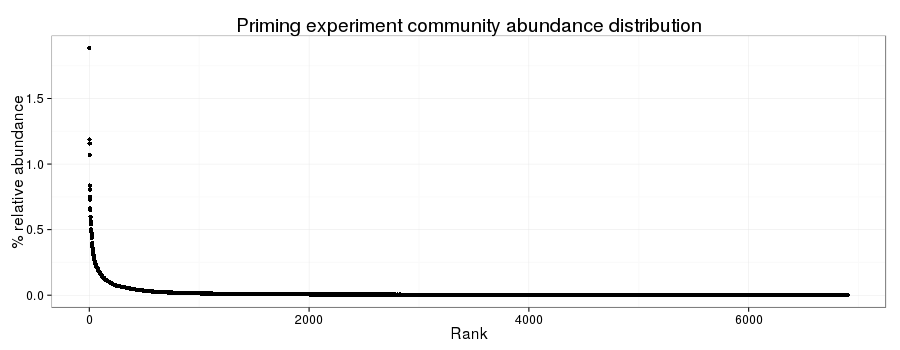

In [12]:
%%R -w 900 -h 350

ggplot(comm, aes(rank, rel_abund_perc)) +
    geom_point() +
    labs(x='Rank', y='% relative abundance', title='Priming experiment community abundance distribution') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

# Simulating fragments

## Making a genome index file to map genome fasta files to OTUs

* Will be used for community simulation
* Just OTUs with association to genomes

In [13]:
%%R -i taxonMapFile -i genomeFilterFile 

taxonMap = read.delim(taxonMapFile, sep='\t') %>%
    select(target_genome, OTU) %>%
    distinct()
taxonMap %>% nrow %>% print
taxonMap %>% head(n=3) %>% print

breaker = '----------------\n'
cat(breaker)

genomeFilter = read.delim(genomeFilterFile, sep='\t', header=F) 
genomeFilter %>% nrow %>% print
genomeFilter %>% head(n=3) %>% print

cat(breaker)

comm = read.delim(commFile, sep='\t') 
comm %>% nrow %>% print
comm %>% head(n=3) %>% print

[1] 236
                               target_genome      OTU
1 CP001738_Thermomonospora_curvata_DSM_43183 OTU.8540
2 CP001738_Thermomonospora_curvata_DSM_43183 OTU.9267
3 CP001738_Thermomonospora_curvata_DSM_43183 OTU.1457
----------------
[1] 187
                                                         V1
1                  CP003093_Pseudoxanthomonas_spadix_BD_a59
2                  CP000511_Mycobacterium_vanbaalenii_PYR_1
3 CP003344_Desulfitobacterium_dichloroeliminans_LMG_P_21439
                                                                                                            V2
1                  /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Pseudoxanthomonas_spadix_BD-a59.fasta
2                  /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Mycobacterium_vanbaalenii_PYR-1.fasta
3 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Desulfitobacterium_dichloroeliminans_LMG_P-21439.fasta
----------------
[1] 6901
  library taxon_name rel_abund_perc rank


In [14]:
%%R
taxonMap$OTU %>% table %>% sort(decreasing=T) %>% head

.
    OTU.1    OTU.10   OTU.101   OTU.102 OTU.10237  OTU.1035 
        1         1         1         1         1         1 


In [15]:
%%R

tbl.j = inner_join(taxonMap, genomeFilter, c('target_genome' = 'V1')) %>%
     rename('fasta_file' = V2) %>%
     select(OTU, fasta_file, target_genome)

tbl.j %>% head(n=3)

       OTU
1 OTU.8540
2 OTU.9267
3 OTU.1457
                                                                                     fasta_file
1 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Thermomonospora_curvata_DSM_43183.fasta
2 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Thermomonospora_curvata_DSM_43183.fasta
3 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Thermomonospora_curvata_DSM_43183.fasta
                               target_genome
1 CP001738_Thermomonospora_curvata_DSM_43183
2 CP001738_Thermomonospora_curvata_DSM_43183
3 CP001738_Thermomonospora_curvata_DSM_43183


In [16]:
%%R
tbl.j$OTU %>% table %>% sort(decreasing=T) %>% head

.
    OTU.1    OTU.10   OTU.101   OTU.102 OTU.10237  OTU.1035 
        1         1         1         1         1         1 


In [17]:
%%R
tbl.j2 = inner_join(tbl.j, comm, c('OTU' = 'taxon_name')) 

n.target.genomes = tbl.j2$OTU %>% unique %>% length
cat('Number of target OTUs: ', n.target.genomes, '\n')
cat('--------', '\n')
tbl.j2 %>% head(n=3)

Number of target OTUs:  196 
-------- 
       OTU
1 OTU.9267
2 OTU.1457
3   OTU.77
                                                                                     fasta_file
1 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Thermomonospora_curvata_DSM_43183.fasta
2 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Thermomonospora_curvata_DSM_43183.fasta
3   /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Pseudoxanthomonas_spadix_BD-a59.fasta
                               target_genome library rel_abund_perc rank
1 CP001738_Thermomonospora_curvata_DSM_43183       1    0.003132433 4370
2 CP001738_Thermomonospora_curvata_DSM_43183       1    0.011451281 1176
3   CP003093_Pseudoxanthomonas_spadix_BD_a59       1    0.028904303  569


In [18]:
%%R -i workDir

outFile = paste(c(workDir, 'target_genome_index.txt'), collapse='/')
write.table(tbl.j2, outFile, sep='\t', quote=F, row.names=F, col.names=F)

## Plotting community abundance distribution of target genomes

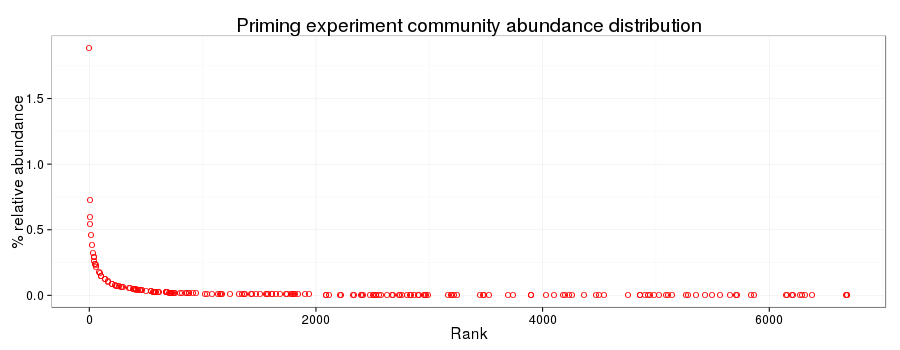

In [19]:
%%R -w 900 -h 350

ggplot(tbl.j2, aes(rank, rel_abund_perc)) +
    geom_point(size=3, shape='O', color='red') +
    labs(x='Rank', y='% relative abundance', title='Priming experiment community abundance distribution') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

## Simulating fragments of genomes that match priming_exp bulk OTUs

In [20]:
!cd $workDir; \
    SIPSim fragments \
    target_genome_index.txt \
    --fp $genomeDir \
    --fr $primerFile \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np $nprocs \
    2> ampFrags.log \
    > ampFrags.pkl        

## Appending fragments from randomly selected genomes of total dataset (n=1210)

* This is to obtain the richness of the bulk soil community
* Random OTUs will be named after non-target OTUs in comm file

### Making list of non-target OTUs

In [21]:
%%R -i workDir
# loading files

## target genome index (just OTUs with associated genome)
inFile = paste(c(workDir, 'target_genome_index.txt'), collapse='/')
tbl.target = read.delim(inFile, sep='\t', header=F)
colnames(tbl.target) = c('OTUId', 'fasta_file', 'genome_name')

## comm file of total community OTUs 
commFile = paste(c(workDir, 'comm.txt'), collapse='/')
tbl.comm = read.delim(commFile, sep='\t')

In [22]:
%%R
# just OTUs w/out an associated genome
tbl.j = anti_join(tbl.comm, tbl.target, c('taxon_name' = 'OTUId'))
n.nontarget.genomes = tbl.j$taxon_name %>% length
cat('Number of non-target genomes: ', n.nontarget.genomes, '\n')
cat('---------\n')
tbl.j %>% head(n=5)

Number of non-target genomes:  6705 
---------
  library taxon_name rel_abund_perc rank
1       1   OTU.8166   0.0004756572 6901
2       1   OTU.8112   0.0004756572 6900
3       1   OTU.7281   0.0004756572 6899
4       1   OTU.7101   0.0004756572 6898
5       1   OTU.6733   0.0004756572 6897


In [23]:
%%R -i comm_richness
# checking assumptions
cat('Target + nonTarget richness = total community richness?: ',
    n.target.genomes + n.nontarget.genomes == comm_richness, '\n')

Target + nonTarget richness = total community richness?:  TRUE 


In [24]:
%%R -i workDir
# writing out non-target OTU file
outFile = paste(c(workDir, 'comm_nonTarget.txt'), collapse='/')
write.table(tbl.j, outFile, sep='\t', quote=F, row.names=F)

### Randomly selecting amplicon fragment length-GC KDEs from total genome pool

In [25]:
# List of non-target OTUs
inFile = os.path.join(workDir, 'comm_nonTarget.txt')
nonTarget = pd.read_csv(inFile, sep='\t')['taxon_name'].tolist()

print 'Number of non-target OTUs: {}'.format(len(nonTarget))
nonTarget[:4]

Number of non-target OTUs: 6705


['OTU.8166', 'OTU.8112', 'OTU.7281', 'OTU.7101']

In [26]:
# loading amplicon fragments from full genome KDE dataset
inFile = os.path.join(workDir, 'ampFrags.pkl')
ampFrag_target = []
with open(inFile, 'rb') as iFH:
    ampFrag_target = pickle.load(iFH)
print 'Target OTU richness: {}'.format(len(ampFrag_target))

Target OTU richness: 196


In [27]:
# loading amplicon fragments from full genome KDE dataset
ampFrag_all = []
with open(allAmpFrags, 'rb') as iFH:
    ampFrag_all = pickle.load(iFH)
print 'Count of frag-GC KDEs for all genomes: {}'.format(len(ampFrag_all))    

Count of frag-GC KDEs for all genomes: 1210


In [28]:
# random selection from list
#target_richness = len(ampFrag_target)

target_richness = len(ampFrag_target)
richness_needed = comm_richness - target_richness
print 'Number of random taxa needed to reach richness: {}'.format(richness_needed)

if richness_needed > 0:
    index = range(target_richness)
    index = np.random.choice(index, richness_needed)
    
    ampFrag_rand = []
    for i in index:
        sys.stderr.write('{},'.format(i))
        ampFrag_rand.append(copy.deepcopy(ampFrag_all[i]))
else:
    ampFrag_rand = []

3,2,154,67,51,152,133,99,67,163,176,95,101,27,61,36,165,49,110,190,50,20,7,49,164,137,79,4,9,195,5,30,107,84,161,143,96,18,174,100,147,161,134,145,100,163,128,94,150,114,168,110,51,60,58,73,89,87,189,49,92,11,4,42,132,30,96,3,135,72,193,151,113,79,186,152,120,56,92,155,186,1,73,7,174,74,67,182,157,12,112,140,67,69,159,29,140,89,183,53,110,136,121,32,86,42,87,67,100,63,179,68,43,178,64,78,149,6,1,43,155,47,142,52,39,55,152,109,24,164,138,56,120,105,113,73,64,126,120,160,92,92,39,26,129,0,16,176,75,146,151,39,12,118,73,45,73,164,75,4,66,128,125,159,79,174,16,147,6,109,88,162,61,85,192,191,79,68,105,174,87,175,99,138,141,171,27,90,152,34,110,7,29,179,60,46,97,120,192,14,33,103,165,122,183,103,103,75,76,164,188,139,1,119,32,187,149,30,89,167,56,89,31,162,154,41,137,123,59,110,195,100,104,163,158,138,72,142,150,143,12,135,40,114,168,27,10,63,28,173,94,105,122,67,168,93,63,22,35,193,51,77,98,174,128,72,145,114,144,139,0,161,156,75,111,111,172,64,16,38,0,55,11,66,65,103,91,52,22,72,143,23,12,

Number of random taxa needed to reach richness: 6705


In [ ]:
# renaming randomly selected KDEs by non-target OTU-ID
for i in range(len(ampFrag_rand)):
    ampFrag_rand[i][0] = nonTarget[i]

In [ ]:
# appending random taxa to target taxa and writing
outFile = os.path.join(workDir, 'ampFrags_wRand.pkl')

with open(outFile, 'wb') as oFH:
    x = ampFrag_target + ampFrag_rand
    print 'Number of taxa in output: {}'.format(len(x))
    pickle.dump(x, oFH)

# Converting fragments to kde object

In [ ]:
!cd $workDir; \
    SIPSim fragment_kde \
    ampFrags_wRand.pkl \
    > ampFrags_wRand_kde.pkl

# Adding diffusion

In [ ]:
!cd $workDir; \
    SIPSim diffusion \
    ampFrags_wRand_kde.pkl \
    --np $nprocs \
    > ampFrags_wRand_kde_dif.pkl    

# Making an incorp config file

In [ ]:
!cd $workDir; \
    SIPSim incorpConfigExample \
    --percTaxa 0 \
    --percIncorpUnif 100 \
    > PT0_PI100.config

# Adding isotope incorporation to BD distribution

In [ ]:
!cd $workDir; \
    SIPSim isotope_incorp \
    ampFrags_wRand_kde_dif.pkl \
    PT0_PI100.config \
    --comm comm.txt \
    --np $nprocs \
    > ampFrags_wRand_kde_dif_incorp.pkl

# Calculating BD shift from isotope incorporation

In [ ]:
!cd $workDir; \
    SIPSim BD_shift \
    ampFrags_wRand_kde_dif.pkl \
    ampFrags_wRand_kde_dif_incorp.pkl \
    --np $nprocs \
    > ampFrags_wRand_kde_dif_incorp_BD-shift.txt

# Simulating gradient fractions

In [ ]:
!cd $workDir; \
    SIPSim gradient_fractions \
    comm.txt \
    > fracs.txt

# Simulating an OTU table

In [ ]:
!cd $workDir; \
    SIPSim OTU_table \
    ampFrags_wRand_kde_dif_incorp.pkl \
    comm.txt \
    fracs.txt \
    --abs 1e9 \
    --np $nprocs \
    > OTU_abs1e9.txt

## Plotting taxon abundances

In [12]:
%%R -i workDir
setwd(workDir)

# loading file
tbl = read.delim('OTU_abs1e9.txt', sep='\t')

In [13]:
%%R
## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

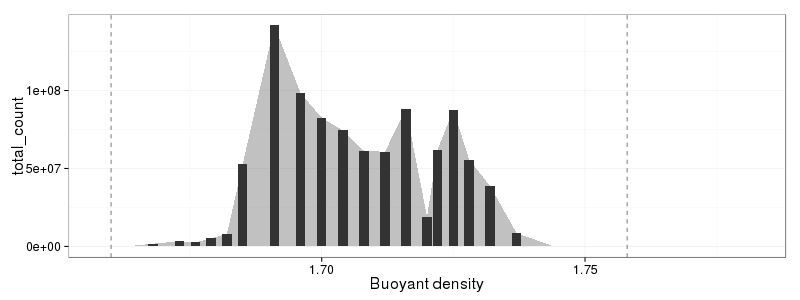

In [14]:
%%R -w 800 -h 300
# plotting absolute abundances

tbl.s = tbl %>%
    group_by(library, BD_mid) %>%
    summarize(total_count = sum(count))

## plot
p = ggplot(tbl.s, aes(BD_mid, total_count)) +
    geom_area(stat='identity', alpha=0.3, position='dodge') +
    geom_histogram(stat='identity') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16) 
    )
p

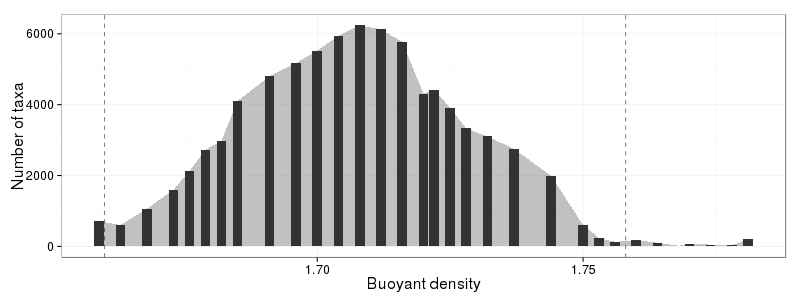

In [15]:
%%R -w 800 -h 300
# plotting number of taxa at each BD

tbl.nt = tbl %>%
    filter(count > 0) %>%
    group_by(library, BD_mid) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(tbl.nt, aes(BD_mid, n_taxa)) +
    geom_area(stat='identity', alpha=0.3, position='dodge') +
    geom_histogram(stat='identity') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

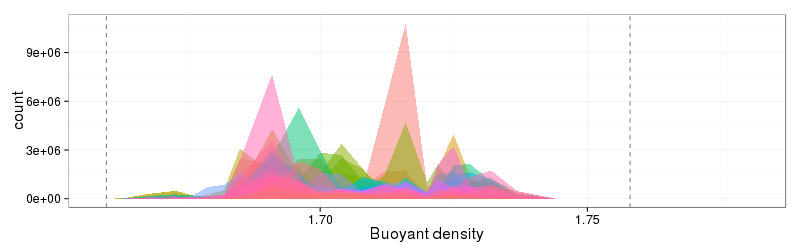

In [16]:
%%R -w 800 -h 250
# plotting relative abundances

## plot
p = ggplot(tbl, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity', position='dodge', alpha=0.5)

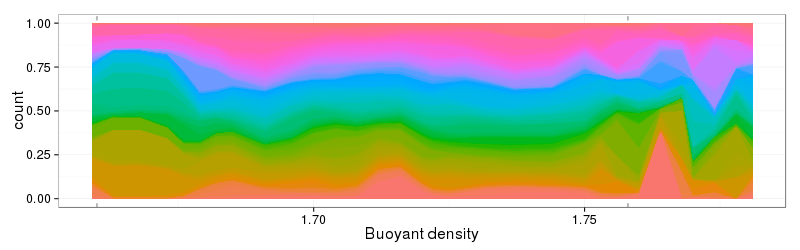

In [17]:
%%R -w 800 -h 250

p + geom_area(stat='identity', position='fill')

# Subsampling from the OTU table

In [ ]:
dist,loc,scale = seq_per_fraction

!cd $workDir; \
    SIPSim OTU_subsample \
    --dist $dist \
    --dist_params mean:$loc,sigma:$scale \
    --walk 2 \
    --min_size 10000 \
    --max_size 200000 \
    OTU_abs1e9.txt \
    > OTU_abs1e9_sub.txt  

### Testing/Plotting seq count distribution of subsampled fraction samples

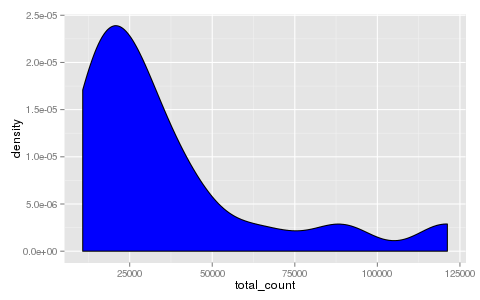

In [18]:
%%R -h 300 -i workDir
setwd(workDir)

tbl = read.csv('OTU_abs1e9_sub.txt', sep='\t') 

tbl.s = tbl %>% 
    group_by(library, fraction) %>%
    summarize(total_count = sum(count)) %>%
    ungroup() %>%
    mutate(library = as.character(library))

ggplot(tbl.s, aes(total_count)) +
    geom_density(fill='blue')

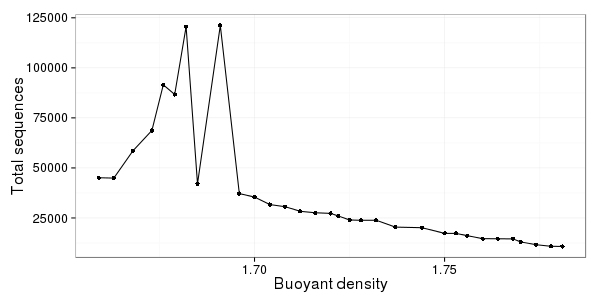

In [19]:
%%R -h 300 -w 600
setwd(workDir)

tbl.s = tbl %>%
    group_by(fraction, BD_min, BD_mid, BD_max) %>%
    summarize(total_count = sum(count)) 

ggplot(tbl.s, aes(BD_mid, total_count)) +
    geom_point() +
    geom_line() +
    labs(x='Buoyant density', y='Total sequences') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

## Getting list of target taxa

In [20]:
%%R -i workDir

inFile = paste(c(workDir, 'target_genome_index.txt'), collapse='/')

tbl.target = read.delim(inFile, sep='\t', header=F)
colnames(tbl.target) = c('OTUId', 'genome_file', 'genome_ID', 'X', 'Y', 'Z')
tbl.target = tbl.target %>% distinct(OTUId)


cat('Number of target OTUs: ', tbl.target$OTUId %>% unique %>% length, '\n')
cat('----------\n')
tbl.target %>% head(n=3)

Number of target OTUs:  196 
----------
     OTUId
1 OTU.9267
2 OTU.1457
3   OTU.77
                                                                                    genome_file
1 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Thermomonospora_curvata_DSM_43183.fasta
2 /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Thermomonospora_curvata_DSM_43183.fasta
3   /home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/Pseudoxanthomonas_spadix_BD-a59.fasta
                                   genome_ID X           Y    Z
1 CP001738_Thermomonospora_curvata_DSM_43183 1 0.003132433 4370
2 CP001738_Thermomonospora_curvata_DSM_43183 1 0.011451281 1176
3   CP003093_Pseudoxanthomonas_spadix_BD_a59 1 0.028904303  569


## Plotting abundance distributions

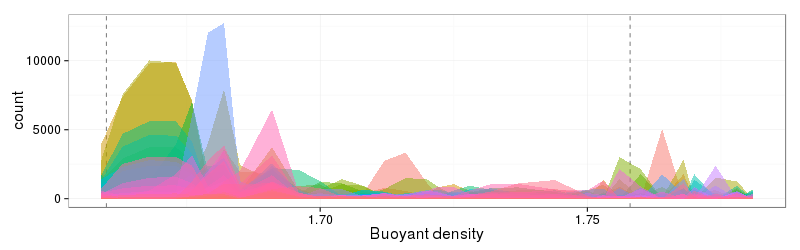

In [21]:
%%R -w 800 -h 250
# plotting relative abundances

tbl = tbl %>% 
    group_by(fraction) %>%
    mutate(rel_abund = count / sum(count))


## plot
p = ggplot(tbl, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity', position='dodge', alpha=0.5)

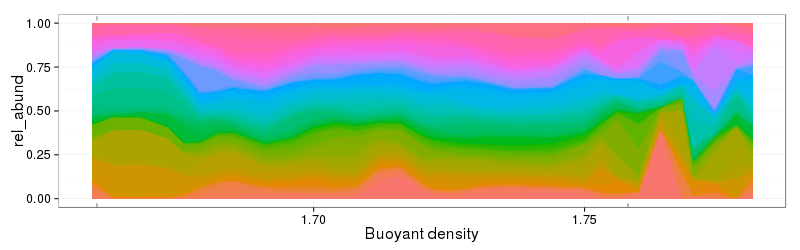

In [22]:
%%R -w 800 -h 250

p = ggplot(tbl, aes(BD_mid, rel_abund, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity')

### Abundance distribution of just target taxa

In [23]:
%%R

targets = tbl.target$OTUId %>% as.vector %>% unique 

tbl.f = tbl %>%
    filter(taxon %in% targets)

tbl.f %>% head

Source: local data frame [6 x 8]
Groups: fraction

  library    fraction taxon BD_min BD_mid BD_max count rel_abund
1       1  -inf-1.660 OTU.1   -Inf  1.659  1.659     0         0
2       1 1.660-1.666 OTU.1  1.660  1.663  1.666     0         0
3       1 1.666-1.671 OTU.1  1.666  1.668  1.671     0         0
4       1 1.671-1.675 OTU.1  1.671  1.673  1.675     0         0
5       1 1.675-1.678 OTU.1  1.675  1.676  1.678     0         0
6       1 1.678-1.681 OTU.1  1.678  1.679  1.681     0         0


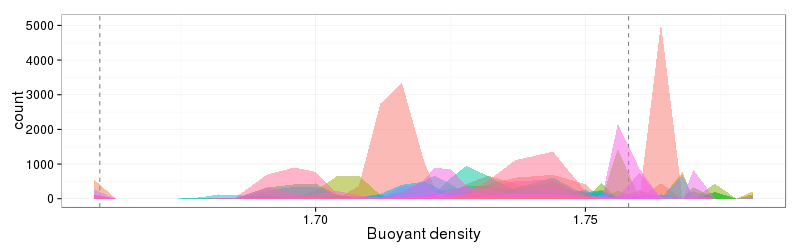

In [24]:
%%R -w 800 -h 250
# plotting absolute abundances

## plot
p = ggplot(tbl.f, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity', position='dodge', alpha=0.5)

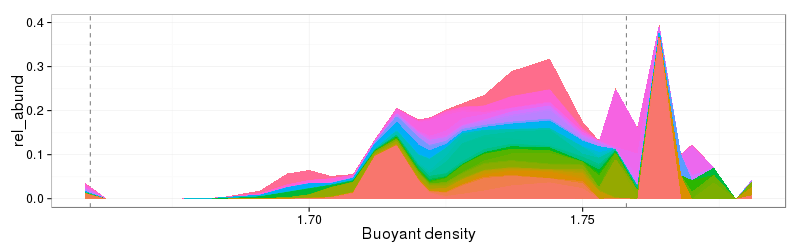

In [25]:
%%R -w 800 -h 250
# plotting relative abundances

p = ggplot(tbl.f, aes(BD_mid, rel_abund, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity')

# Plotting 'true' taxon abundance distribution (from priming exp dataset)

In [26]:
%%R -i metaDataFile
# loading priming_exp metadata file

meta = read.delim(metaDataFile, sep='\t')
meta %>% head(n=4)

            Sample FractionNum Bulk Control CC X100 X700 H2O Day Density rep
1 12C.000.28.03.07           7    0       1  1    0    0   0  28  1.7646    
2 12C.000.28.03.08           8    0       1  1    0    0   0  28  1.7614    
3 12C.000.28.03.09           9    0       1  1    0    0   0  28  1.7537    
4 12C.000.28.03.10          10    0       1  1    0    0   0  28  1.7483    
  contolVlabel Treatment
1      control    12C000
2      control    12C000
3      control    12C000
4      control    12C000


In [27]:
%%R -i otuTableFile
# loading priming_exp OTU table 

tbl.otu.true = read.delim(otuTableFile, sep='\t') %>%
    select(OTUId, starts_with('X12C.700.28')) 
tbl.otu.true %>% head(n=3)

     OTUId X12C.700.28.04.05 X12C.700.28.04.04 X12C.700.28.04.21
1 OTU.4776                62               179                87
2 OTU.2864                 1                 0                 0
3 OTU.8170                 0                 0                 0
  X12C.700.28.04.09 X12C.700.28.04.11 X12C.700.28.04.14 X12C.700.28.04.NA
1                63                31                 9                54
2                 0                 0                 0                 0
3                 0                 0                 0                 0
  X12C.700.28.04.08 X12C.700.28.04.12 X12C.700.28.04.20 X12C.700.28.04.02
1                69                29               294               338
2                 0                 2                 0                 1
3                 0                 0                 0                 0
  X12C.700.28.04.10 X12C.700.28.04.13 X12C.700.28.04.06 X12C.700.28.04.03
1                75                11                66                74


In [28]:
%%R
# editing table
tbl.otu.true.w = tbl.otu.true %>%
    gather('sample', 'count', 2:ncol(tbl.otu.true)) %>%
    mutate(sample = gsub('^X', '', sample)) %>%
    group_by(sample) %>%
    mutate(rel_abund = count / sum(count)) %>%
    ungroup() %>%
    filter(count > 0)
tbl.otu.true.w %>% head(n=5)

Source: local data frame [5 x 4]

     OTUId           sample count    rel_abund
1 OTU.4776 12C.700.28.04.05    62 2.228532e-03
2 OTU.2864 12C.700.28.04.05     1 3.594407e-05
3 OTU.6001 12C.700.28.04.05     1 3.594407e-05
4  OTU.611 12C.700.28.04.05     7 2.516085e-04
5  OTU.961 12C.700.28.04.05     4 1.437763e-04


In [29]:
%%R
tbl.true.j = inner_join(tbl.otu.true.w, meta, c('sample' = 'Sample'))
tbl.true.j %>% as.data.frame %>% head(n=3)

     OTUId           sample count    rel_abund FractionNum Bulk Control CC X100
1 OTU.4776 12C.700.28.04.05    62 2.228532e-03           5    0       1  0    0
2 OTU.2864 12C.700.28.04.05     1 3.594407e-05           5    0       1  0    0
3 OTU.6001 12C.700.28.04.05     1 3.594407e-05           5    0       1  0    0
  X700 H2O Day Density rep contolVlabel Treatment
1    1   0  28  1.7515          control    12C700
2    1   0  28  1.7515          control    12C700
3    1   0  28  1.7515          control    12C700


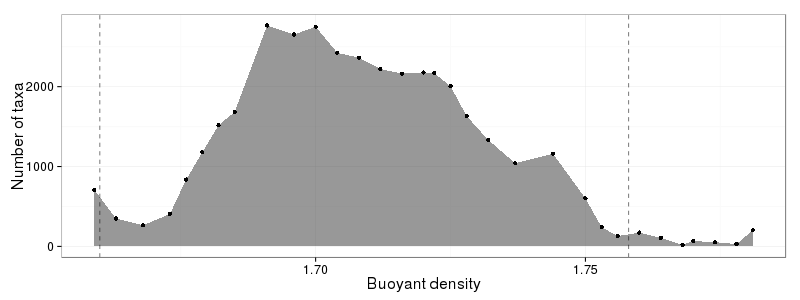

In [30]:
%%R -w 800 -h 300  -i workDir
# plotting number of taxa at each BD

tbl = read.csv('OTU_abs1e9_sub.txt', sep='\t') 

tbl.nt = tbl %>%
    filter(count > 0) %>%
    group_by(library, BD_mid) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(tbl.nt, aes(BD_mid, n_taxa)) +
    geom_area(stat='identity', alpha=0.5) +
    geom_point() +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

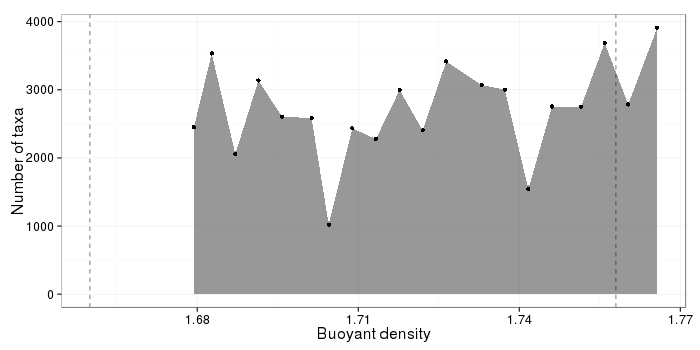

In [31]:
%%R -w 700 -h 350

tbl.true.j.s = tbl.true.j %>%
    filter(count > 0) %>%
    group_by(sample, Density) %>%
    summarize(n_taxa = sum(count > 0))

ggplot(tbl.true.j.s, aes(Density, n_taxa)) +
    geom_area(stat='identity', alpha=0.5) +
    geom_point() +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )

### Plotting total counts for each sample

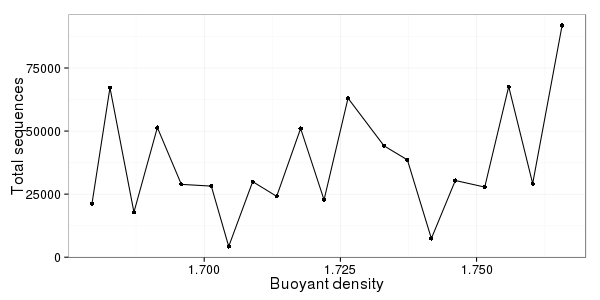

In [32]:
%%R -h 300 -w 600
tbl.true.j.s = tbl.true.j %>%
    group_by(sample, Density) %>%
    summarize(total_count = sum(count)) 

ggplot(tbl.true.j.s, aes(Density, total_count)) +
    geom_point() +
    geom_line() +
    labs(x='Buoyant density', y='Total sequences') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

### Plotting abundance distribution of target OTUs

In [33]:
%%R
tbl.true.j.f = tbl.true.j %>%
    filter(OTUId %in% targets) %>%
    arrange(OTUId, Density) %>%
    group_by(sample)
tbl.true.j.f %>% head(n=3) %>% as.data.frame

  OTUId           sample count   rel_abund FractionNum Bulk Control CC X100
1 OTU.1 12C.700.28.04.21   251 0.011817882          21    0       1  0    0
2 OTU.1 12C.700.28.04.20   639 0.009510061          20    0       1  0    0
3 OTU.1 12C.700.28.04.19   132 0.007396201          19    0       1  0    0
  X700 H2O Day Density rep contolVlabel Treatment
1    1   0  28  1.6794          control    12C700
2    1   0  28  1.6827          control    12C700
3    1   0  28  1.6871          control    12C700


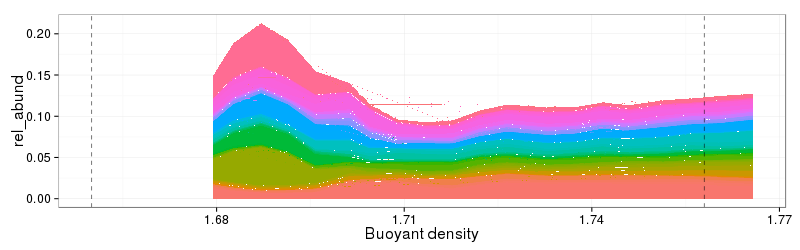

In [34]:
%%R -w 800 -h 250
# plotting relative abundances

## plot
ggplot(tbl.true.j.f, aes(Density, rel_abund, fill=OTUId)) +
    geom_area(stat='identity') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )

## Combining true and simulated OTU tables for target taxa

In [35]:
%%R
tbl.f.e = tbl.f %>%
    mutate(library = 'simulation') %>%
    rename('density' = BD_mid) %>%
    select(-BD_min, -BD_max)

tbl.true.e = tbl.true.j.f %>% 
    select('taxon' = OTUId,
           'fraction' = sample,
           'density' = Density,
           count, rel_abund) %>%
    mutate(library = 'true') 
           
           
tbl.sim.true = rbind(tbl.f.e, tbl.true.e) %>% as.data.frame
tbl.f.e = data.frame()
tbl.true.e = data.frame()

tbl.sim.true %>% head(n=3)

     library    fraction taxon density count rel_abund
1 simulation  -inf-1.660 OTU.1   1.659     0         0
2 simulation 1.660-1.666 OTU.1   1.663     0         0
3 simulation 1.666-1.671 OTU.1   1.668     0         0


In [36]:
%%R
# check
cat('Number of target taxa: ', tbl.sim.true$taxon %>% unique %>% length, '\n')

Number of target taxa:  196 


## Abundance distributions of each target taxon

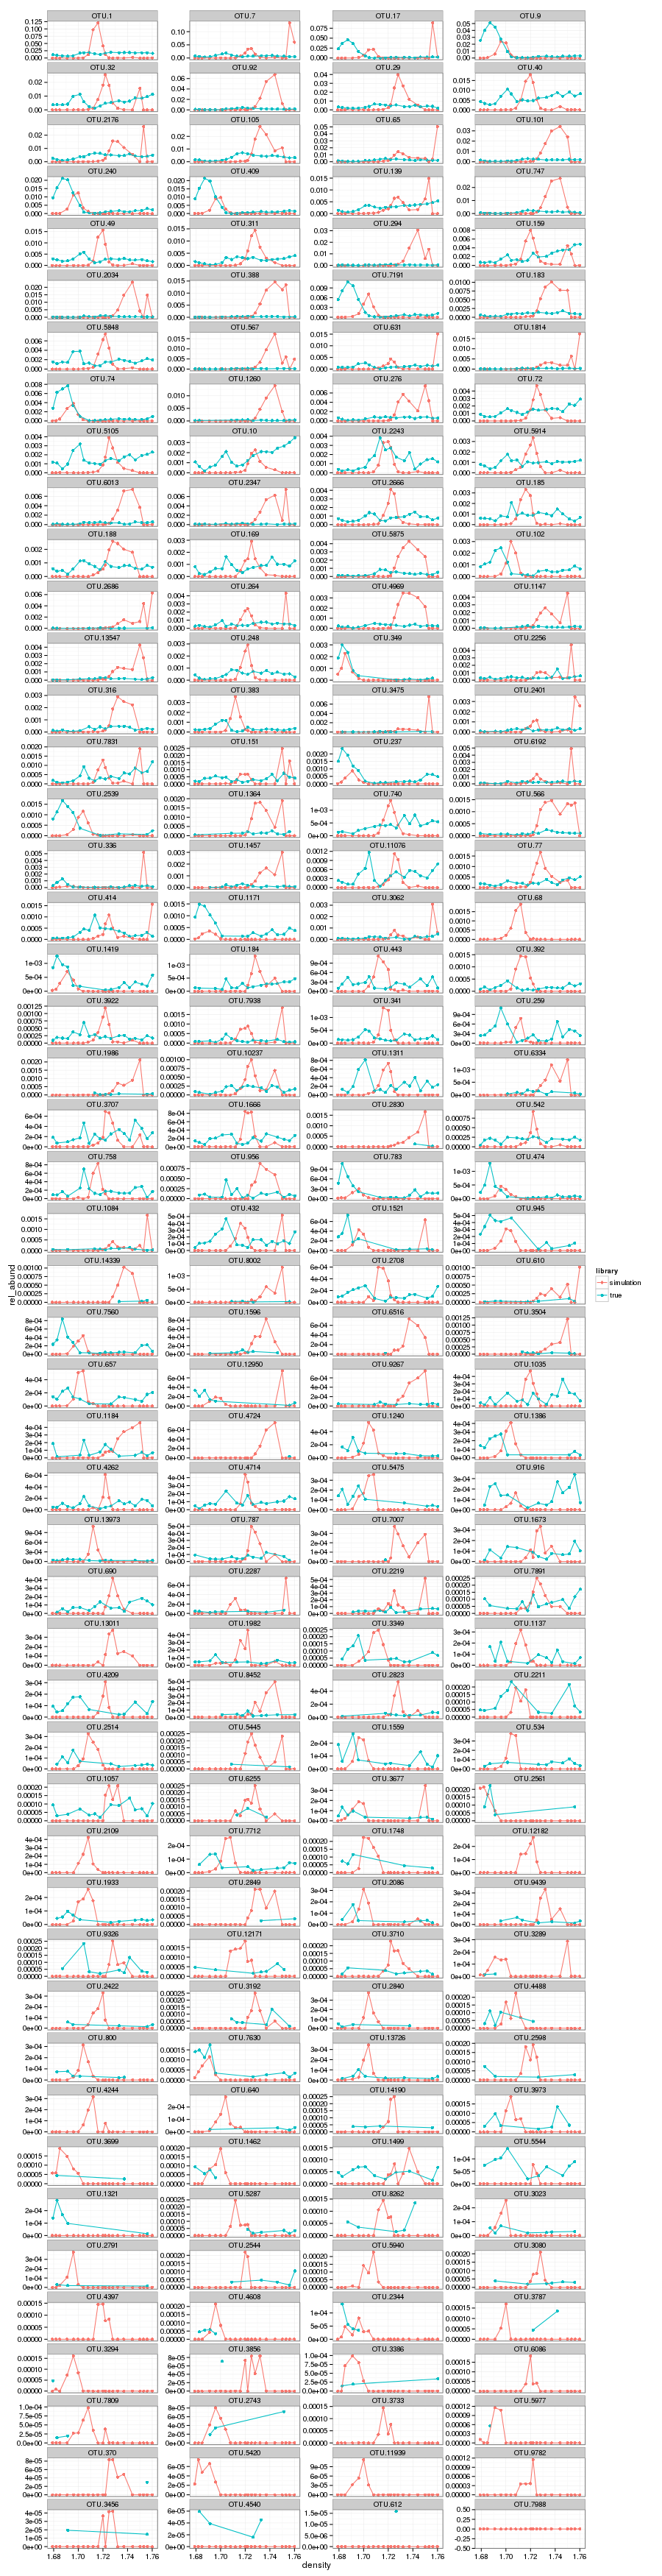

In [37]:
%%R -w 900 -h 3500

tbl.sim.true.f = tbl.sim.true %>%
    ungroup() %>%
    filter(density >= 1.677) %>%
    filter(density <= 1.761) %>%
    group_by(taxon) %>%
    mutate(mean_rel_abund = mean(rel_abund))  %>%
    ungroup()

tbl.sim.true.f$taxon = reorder(tbl.sim.true.f$taxon, -tbl.sim.true.f$mean_rel_abund)

ggplot(tbl.sim.true.f, aes(density, rel_abund, color=library)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    facet_wrap(~ taxon, ncol=4, scales='free_y')

In [38]:
%%R
tbl.otu.true.w %>% 
    filter(OTUId == 'OTU.1') %>%
    as.data.frame()

   OTUId           sample count   rel_abund
1  OTU.1 12C.700.28.04.05   507 0.018223644
2  OTU.1 12C.700.28.04.04  1210 0.017891997
3  OTU.1 12C.700.28.04.21   251 0.011817882
4  OTU.1 12C.700.28.04.09   811 0.018365036
5  OTU.1 12C.700.28.04.11   377 0.016576529
6  OTU.1 12C.700.28.04.14   565 0.018848412
7  OTU.1 12C.700.28.04.NA   309 0.012253153
8  OTU.1 12C.700.28.04.08   721 0.018693285
9  OTU.1 12C.700.28.04.12   620 0.012148049
10 OTU.1 12C.700.28.04.20   639 0.009510061
11 OTU.1 12C.700.28.04.02  1373 0.014942591
12 OTU.1 12C.700.28.04.10  1244 0.019733190
13 OTU.1 12C.700.28.04.13   349 0.014465122
14 OTU.1 12C.700.28.04.06   547 0.017980409
15 OTU.1 12C.700.28.04.03   466 0.015967106
16 OTU.1 12C.700.28.03.NA   165 0.010305415
17 OTU.1 12C.700.28.04.15    77 0.017994859
18 OTU.1 12C.700.28.04.18   348 0.006770560
19 OTU.1 12C.700.28.04.07   139 0.018735679
20 OTU.1 12C.700.28.04.19   132 0.007396201
21 OTU.1 12C.700.28.04.16   473 0.016767104
22 OTU.1 12C.700.28.04.17   221 

In [40]:
%%R
tbl.sim.true.f %>%
    filter(taxon == 'OTU.1') %>%
    as.data.frame()

      library         fraction taxon density count    rel_abund mean_rel_abund
1  simulation      1.678-1.681 OTU.1  1.6790     0 0.000000e+00      0.0143209
2  simulation      1.681-1.683 OTU.1  1.6820     0 0.000000e+00      0.0143209
3  simulation      1.683-1.688 OTU.1  1.6850     0 0.000000e+00      0.0143209
4  simulation      1.688-1.694 OTU.1  1.6910     0 0.000000e+00      0.0143209
5  simulation      1.694-1.698 OTU.1  1.6960     0 0.000000e+00      0.0143209
6  simulation      1.698-1.702 OTU.1  1.7000     1 2.822148e-05      0.0143209
7  simulation      1.702-1.706 OTU.1  1.7040    14 4.411950e-04      0.0143209
8  simulation      1.706-1.710 OTU.1  1.7080   362 1.180730e-02      0.0143209
9  simulation      1.710-1.714 OTU.1  1.7120  2745 9.679808e-02      0.0143209
10 simulation      1.714-1.719 OTU.1  1.7160  3343 1.210793e-01      0.0143209
11 simulation      1.719-1.720 OTU.1  1.7200  1133 4.149271e-02      0.0143209
12 simulation      1.720-1.723 OTU.1  1.7220   329 1